In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Preparation

In [56]:
import pandas as pd
import sys
import os
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline
from nutrimap_app.data_prep_marie import clean_food_data, scale_food_data

import pickle

# Upload the data and clean it using the clean_food_data() function
df = clean_food_data()

# Scale the data using the scale_food_data() function
scaled_df = scale_food_data()

scaled_df.head(10)


,food_item,fat_g,satfat_g,carbs_g,protein_g,fiber_g,energy_kcal_calculated
0,"Garlic, raw",0.00380,0.0,0.282000,0.074955,0.034177,0.158503
1,"Onions, white, raw",0.00130,0.0,0.076800,0.010077,0.015190,0.039320
2,"Apples, red delicious, with skin, raw",0.00210,0.0,0.148000,0.002151,0.025316,0.068644
3,"Apples, honeycrisp, with skin, raw",0.00100,0.0,0.147000,0.001132,0.021519,0.066756
4,"Apples, granny smith, with skin, raw",0.00140,0.0,0.142000,0.003057,0.031646,0.065645
5,"Apples, gala, with skin, raw",0.00150,0.0,0.148000,0.001472,0.026582,0.067866
6,"Apples, fuji, with skin, raw",0.00160,0.0,0.157000,0.001698,0.026582,0.071976
7,"Flour, buckwheat",0.02484,0.0,0.750181,0.100599,0.131013,0.397645
8,"Flour, rye",0.01908,0.0,0.771618,0.095054,0.173165,0.399200
9,"Flour, barley",0.02450,0.0,0.773983,0.098751,0.161899,0.407087


In [47]:
scaled_df.shape

(7521, 7)

In [67]:
X = scaled_df.drop(columns=["food_item"])
y = scaled_df["food_item"]

## Model exploration

In [ ]:
from sklearn.cluster import KMeans


cluster_values = range(2, 11)  # start at 2
inertias = []
silhouette_scores = []
calinski_scores = []
davies_scores = []
predictions = []

for k in cluster_values:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X)
    predictions.append(labels)

    inertias.append(model.inertia_)
    silhouette_scores.append(silhouette_score(X, labels))
    calinski_scores.append(calinski_harabasz_score(X, labels))
    davies_scores.append(davies_bouldin_score(X, labels))

# Print results cleanly
for i, k in enumerate(cluster_values):
    print(f"\n===== k = {k} clusters =====")
    print("Silhouette score:        ", silhouette_scores[i])
    print("Calinski-Harabasz index: ", calinski_scores[i])
    print("Davies-Bouldin index:    ", davies_scores[i])
    print("Inertia:                 ", inertias[i])


===== k = 2 clusters =====
Silhouette score:         0.559617158437876
Calinski-Harabasz index:  6235.595921189171
Davies-Bouldin index:     0.9172370603006238
Inertia:                  626.2579834948868

===== k = 3 clusters =====
Silhouette score:         0.590045341076769
Calinski-Harabasz index:  7299.995891264942
Davies-Bouldin index:     0.6348328851067175
Inertia:                  389.40153197060835

===== k = 4 clusters =====
Silhouette score:         0.49743665289494676
Calinski-Harabasz index:  8553.119612668492
Davies-Bouldin index:     0.7168892704950314
Inertia:                  259.5714106276449

===== k = 5 clusters =====
Silhouette score:         0.49517305740399187
Calinski-Harabasz index:  7784.589742772678
Davies-Bouldin index:     0.7866206169233105
Inertia:                  222.75627522086006

===== k = 6 clusters =====
Silhouette score:         0.489599963543909
Calinski-Harabasz index:  7294.282636018679
Davies-Bouldin index:     0.8612909224105522
Inertia:     

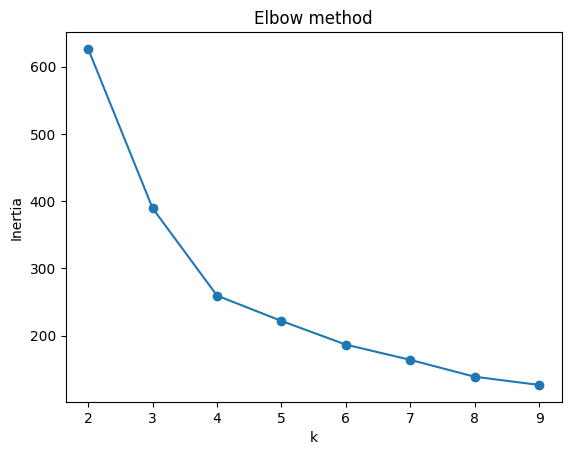

In [112]:
# Evaluate the best cluster number
# Elbow method
import matplotlib.pyplot as plt

plt.plot(cluster_values, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow method")
plt.show()

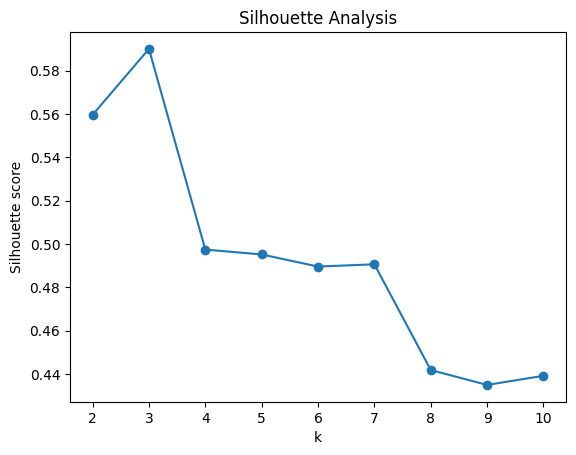

In [123]:
# The higher the score, the better the clustering
plt.plot(cluster_values, silhouette_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Silhouette Analysis")
plt.show()

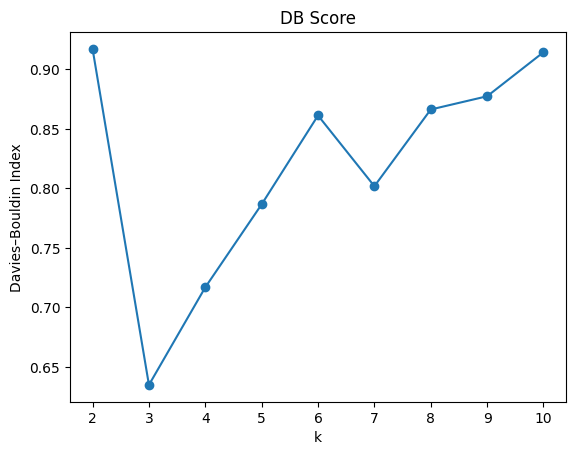

In [ ]:
# The lower the score, the better the clustering
plt.plot(cluster_values, davies_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Davies–Bouldin Index")
plt.title("DB Score")
plt.show()

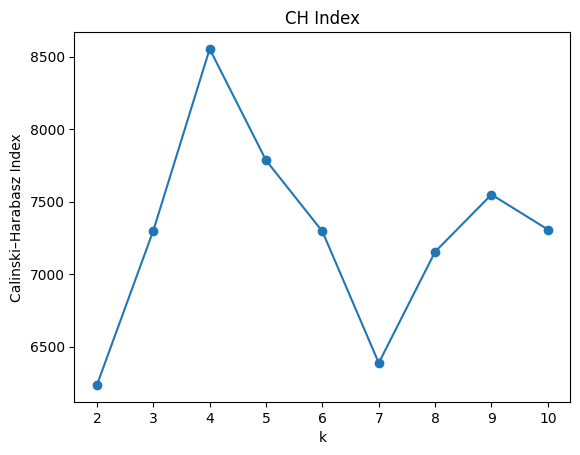

In [125]:
# The higher the score, the better the clustering
plt.plot(cluster_values, calinski_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Calinski–Harabasz Index")
plt.title("CH Index")
plt.show()

# Final Model Definition

In [ ]:
# Final model
k = 3
model = KMeans(n_clusters=k, random_state=42)
clusters = model.fit_predict(X)

In [127]:
df["cluster"] = clusters

In [129]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(X)

# Add the first two principal components as new columns
df["PC1"] = components[:,0]
df["PC2"] = components[:,1]

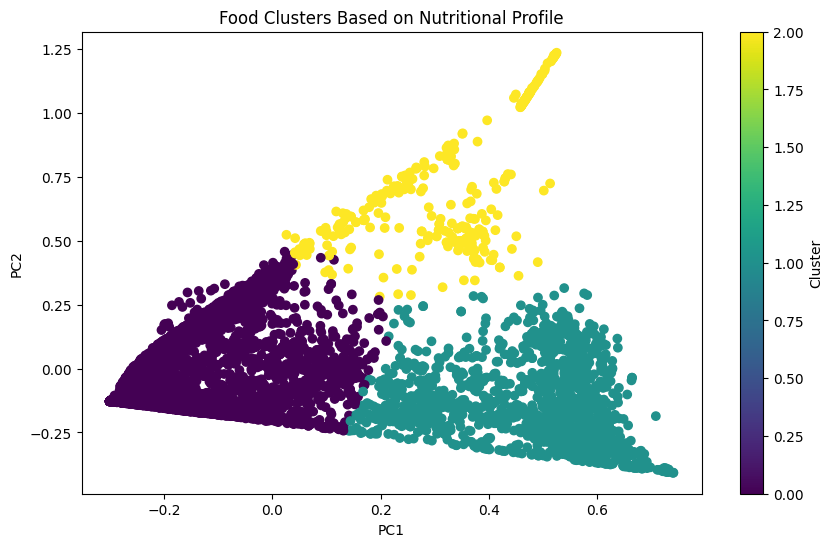

In [130]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
scatter = plt.scatter(df["PC1"], df["PC2"],
                      c=df["cluster"], cmap="viridis")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Food Clusters Based on Nutritional Profile")
plt.colorbar(scatter, label="Cluster")
plt.show()

In [131]:
# Export the model as a pickle file
with open('../models/best_model.pkl', 'wb') as file:
    pickle.dump(model, file)


In [21]:
from nutrimap_app.category_mapping import assign_food_group

def assign_food_group(row):
    food = row["food_item"]
    for group, foods in assign_food_group.items():
        if food in foods:
            return group

df["food_category"] = df.apply(assign_food_group, axis=1)


AttributeError: 'function' object has no attribute 'items'

In [ ]:
# Example prediction

# Load the pipeline
with open('../models/best_model.pkl', 'rb') as file:
    model = pickle.load(file)

# Predict a point
model.predict([[1,1,1,1]])[0]


0